In [24]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt

In [25]:
l = 1
r = 0.05
m = 0.8  # Mass of the rods making up the quadcopter
mrotor = 0.2

m_total = 2*m+4*mrotor
print(m_total)

I1 = 0.5*(m)*(r**2)+2*mrotor*(l/2)**2+(1/12)*m*(3*(r**2)+l**2)
I2 = 0.5*(m)*(r**2)+2*mrotor*(l/2)**2+(1/12)*m*(3*(r**2)+l**2)
I3 = (1/6)*(m*(3*(r**2)+l**2))+4*mrotor*(l/2)**2
I = np.diag((I1,I2,I3))

2.4000000000000004


In [26]:
tau1 = 0.1
tau2 = 0.1
tau3 = 0.1
tau4 = 0.1

L1=74.99167779*tau1
L2=74.99167779*tau2
L3=74.99167779*tau3
L4=74.99167779*tau4

Net_F=(L1+L2+L3+L4)-m_total*9.81
reqd_force=m_total*9.81-Net_F
reqd_torque=reqd_force/(4*74.99167779)
print(Net_F)
print(reqd_force)
print(reqd_torque)


print(m_total*9.81/(4*74.99167779))

6.452671115999998
17.091328884000006
0.056977418653910636
0.07848870932695533


In [27]:
# START TIMESTEPPING

# Initial Conditions:
q0 = np.array([1,0,0,0])
q_array = np.array([[1,0,0,0]])

w0 = np.array([0,0,0])
w_array = np.array([[0,0,0]])

a0=np.array([0,0,0])
a_array=np.array([[0,0,0]])

v0 = np.array([0,0,0])
v_array = np.array([[0,0,0]])

p0 = np.array([0,0,0])
p_array = np.array([[0,0,0]])

Lift_array = np.array([[0,0,0]])

TB_angle_array=np.array([[0,0,0]])

dt = 0.001
iter = 18000

totaltime=dt*iter


# Forward Euler:
for i in range(0,iter):


    if i == 0:
        q = q0
        w = w0
        v = v0
        p = p0
    else:
        q = q_array[i]
        w = w_array[i]
        v = v_array[i]
        p = p_array[i]
    
    if p[2]>-0.5:
        #print("i am here 1")
        tau1 = 0.1
        tau2 = 0.1
        tau3 = 0.1
        tau4 = 0.1

        L1=74.99167779*tau1
        L2=74.99167779*tau2
        L3=74.99167779*tau3
        L4=74.99167779*tau4
    
    elif (p[2]<-0.5 and p[2]>-1):
        #print("i am here 2")
        tau1 = 0.056977418653910636
        tau2 = 0.056977418653910636
        tau3 = 0.056977418653910636
        tau4 = 0.056977418653910636

        L1=74.99167779*tau1
        L2=74.99167779*tau2
        L3=74.99167779*tau3
        L4=74.99167779*tau4

    else:
        #print("i am here 3")
        tau1=0.07848870932695533
        tau2 = 0.07848870932695533
        tau3 = 0.07848870932695533
        tau4 = 0.07848870932695533

        L1=74.99167779*tau1
        L2=74.99167779*tau2
        L3=74.99167779*tau3
        L4=74.99167779*tau4
        a=np.array([0,0,0])   #ELIMINATES RESIDUAL ERROR in acceleration(of the order e-15) and velocity(about 2%)
        v=np.array([0,0,0])
    
    tx = Matrix([0,-l/2,0]).cross(Matrix([0,0,-L4]))+Matrix([0,l/2,0]).cross(Matrix([0,0,-L2]))
    ty = Matrix([l/2,0,0]).cross(Matrix([0,0,-L1]))+Matrix([-l/2,0,0]).cross(Matrix([0,0,-L3]))
    tz = Matrix([0,0,tau1-tau2+tau3-tau4])
    torque_vec = tx+ty+tz
    #print(a)
    #print(v)

    # Current angular acceleration
    w_dot = np.linalg.inv(I)@torque_vec-np.linalg.inv(I)@(Matrix(w).cross(I@Matrix(w)))
    
    # Next timestep angular velocity (Forward Euler)
    w_n1 = w+dt*np.reshape(w_dot,(1,3))
    
    # Add next timestep of angular acceleration to w_array 
    w_array = np.append(w_array,w_n1,axis=0)
    
    # Quarternion q matrix
    norm = np.linalg.norm(np.array([q[0],q[1],q[2],q[3]]).astype('float64'))
    qmat = np.array([[q[0],-q[1],-q[2],-q[3]],
                   [q[1],q[0],q[3],-q[2]],
                   [q[2],-q[3],q[0],q[1]],
                   [q[3],q[2],-q[1],q[0]]])/norm

    # Current q_dot
    q_dot = 0.5*qmat@(np.array([0,w[0],w[1],w[2]]))
    
    # Next timestep q (Forward Euler)
    q_n1 = (q+dt*q_dot).reshape((1,4))

    # Quarternion unit vector from q
    norm2 = np.linalg.norm(np.array([q_n1[0][0],q_n1[0][1],q_n1[0][2],q_n1[0][3]]).astype('float64'))
    qn_u = np.array([[q_n1[0][0],q_n1[0][1],q_n1[0][2],q_n1[0][3]]])/norm2
    
    # Add next timestep of unit vector q to q_array
    q_array = np.append(q_array,qn_u,axis=0)
    
    # Define q's for rotation matrix
    q_u0 = qn_u[0][0]
    q_u1 = qn_u[0][1]
    q_u2 = qn_u[0][2]
    q_u3 = qn_u[0][3]
    
    # Rotation matrix using unit vector q
    R = np.array([[q_u0**2+q_u1**2-q_u2**2-q_u3**2, 2*q_u1*q_u2-2*q_u0*q_u3, 2*q_u1*q_u3+2*q_u0*q_u2],
                [2*q_u1*q_u2+2*q_u0*q_u3, q_u0**2-q_u1**2+q_u2**2-q_u3**2, 2*q_u2*q_u3-2*q_u0*q_u1],
                [2*q_u1*q_u3-2*q_u0*q_u2, 2*q_u2*q_u3+2*q_u0*q_u1, q_u0**2-q_u1**2-q_u2**2+q_u3**2]])
    
    # Lift in non rotated coordinates
    Lift = (R@np.array([0,0,-(L1+L2+L3+L4)])).reshape((1,3)) #Lift is in non rotated coordinates
    Lift_array = np.append(Lift_array,Lift,axis=0)
    
    # Use F = ma to find acceleration
    a = (Lift+np.array([0,0,9.81*(2*m+4*mrotor)]))/(2*m+4*mrotor)

    a_array=np.append(a_array,a,axis=0)

    # FIND the angles at every timestep

    q_present = qn_u[0]

    q0 = np.float32(q_present[0])
    q1 = np.float32(q_present[1])
    q2 = np.float32(q_present[2])
    q3 =np.float32(q_present[3])

    #CONVERT TO TAIT BRYAN ANGLES

    TB_ANGLES = np.array([[np.arctan2(2*(q0*q1+q2*q3),1-2*(q1**2+q2**2))],
                        [-np.pi/2+2*np.arctan2(np.sqrt(1+2*(q0*q2-q1*q3)),np.sqrt(1-2*(q0*q2-q1*q3)))],
                        [np.arctan2(2*(q0*q3+q2*q1),1-2*(q2**2+q3**2))]])
    
    #print("array",TB_angle_array)
    #print("val",TB_ANGLES)
    TB_angle_array=np.append(TB_angle_array,np.transpose(TB_ANGLES),axis=0)
    
    # Next timestep v (Forward Euler)
    v_n1 = v+dt*a
    
    # Add next timestep of v to v_array
    v_array = np.append(v_array,v_n1,axis=0)
    
    # Next timestep p (Forward Euler)
    p_n1 = p+dt*v_n1
    #print(p_n1)
    
    #print(p_n1)
    '''
    if (p_n1[0][2]<-0.5 and p_n1[0][2]>-1):
        print("i am here")
        
    if p_n1[0][2]>-1:
    '''
        
        #break
    
    # Add next timestep p to p_array
    p_array = np.append(p_array,p_n1,axis=0)

#print(TB_angle_array)

# CHANGE CONDITIONS AFTER REACHING HALFWAY POINT

    
#FOR BRINGING BACK INTO ORIGINAL FRAME OF REF
q_present = q_array[-1]

q0 = np.float32(q_present[0])
q1 = np.float32(q_present[1])
q2 = np.float32(q_present[2])
q3 =np.float32(q_present[3])

#CONVERT TO TAIT BRYAN ANGLES

TB_ANGLES = np.array([[np.arctan2(2*(q0*q1+q2*q3),1-2*(q1**2+q2**2))],
                    [-np.pi/2+2*np.arctan2(np.sqrt(1+2*(q0*q2-q1*q3)),np.sqrt(1-2*(q0*q2-q1*q3)))],
                    [np.arctan2(2*(q0*q3+q2*q1),1-2*(q2**2+q3**2))]])

#print(p_array)

In [28]:
import matplotlib.pyplot as plt

posx=p_array[:,0]
posy=p_array[:,1]
posz=p_array[:,2]

velx=v_array[:,0]
vely=v_array[:,1]
velz=v_array[:,2]

ax=a_array[:,0]
ay=a_array[:,1]
az=a_array[:,2]

phi=TB_angle_array[:,0]
theta=TB_angle_array[:,1]
psi=TB_angle_array[:,2]

tarray=np.linspace(0,totaltime,len(posx))

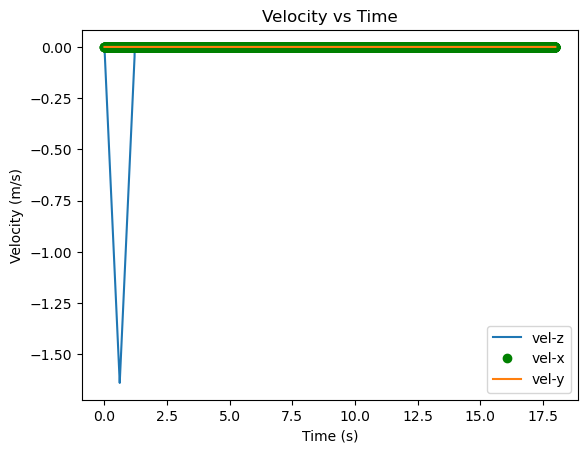

In [29]:
plt.plot(tarray,velz,label='vel-z')
plt.plot(tarray,velx,'go',label='vel-x')
plt.plot(tarray,vely,label='vel-y')
plt.title('Velocity vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

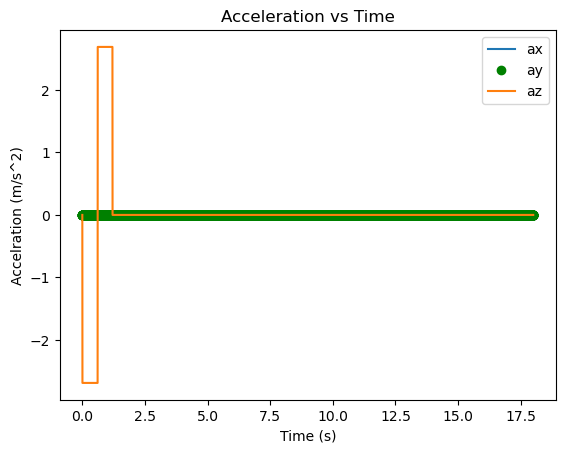

In [30]:
plt.plot(tarray,ax,label='ax')
plt.plot(tarray,ay,'go',label='ay')
plt.plot(tarray,az,label='az')
plt.title('Acceleration vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Accelration (m/s^2)')
plt.legend()
plt.show()

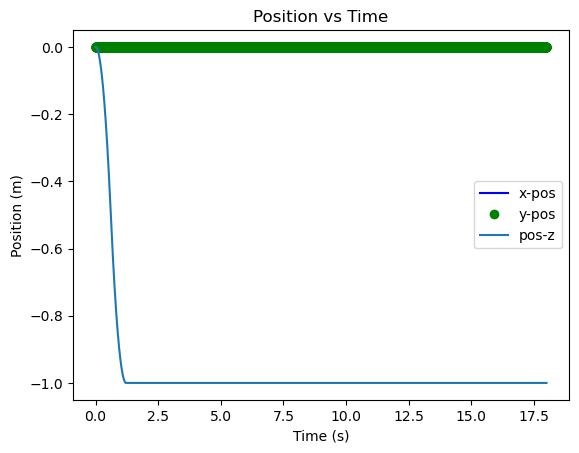

In [31]:
plt.plot(tarray,posx,'b-',label='x-pos')
plt.plot(tarray,posy,'go',label='y-pos')
plt.plot(tarray,posz,label='pos-z')
plt.title('Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.show()

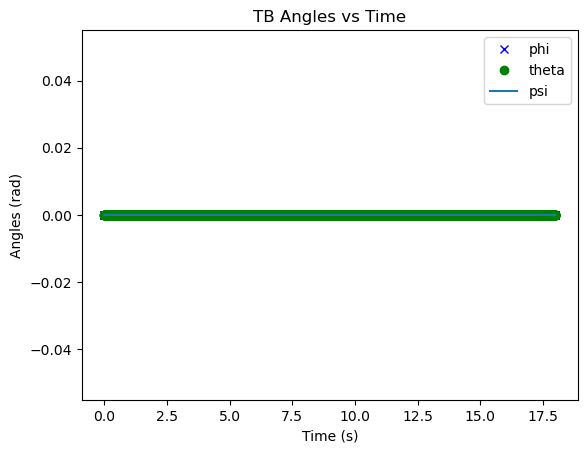

In [32]:
plt.plot(tarray,phi,'bx',label='phi')
plt.plot(tarray,theta,'go',label='theta')
plt.plot(tarray,psi,label='psi')
plt.title('TB Angles vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Angles (rad)')
plt.legend()
plt.show()

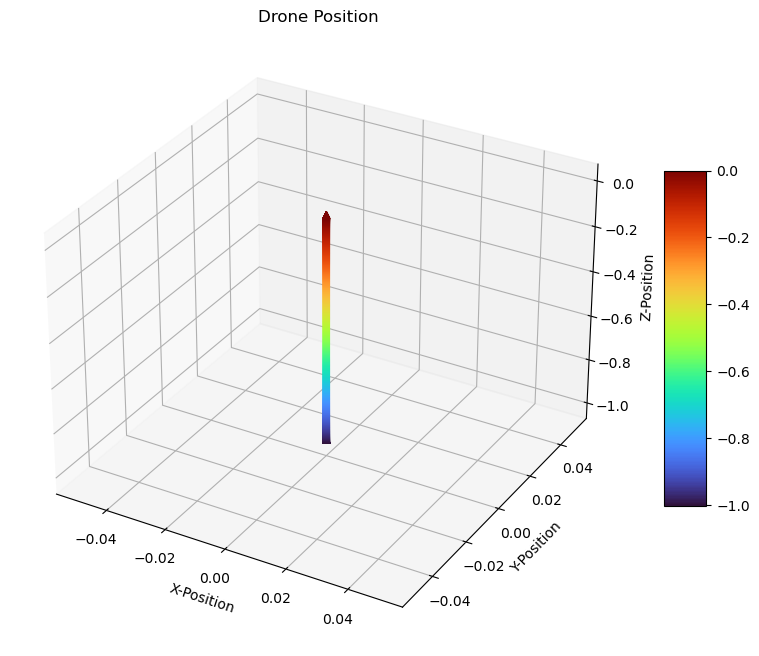

In [33]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,7),tight_layout=True)
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2) 

sctt = ax.scatter3D(posx, posy, posz, alpha = 1, c = (posx + posy + posz), cmap = 'turbo', marker ='^')
 
plt.title("Drone Position")
ax.set_xlabel('X-Position') 
ax.set_ylabel('Y-Position') 
ax.set_zlabel('Z-Position')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 8)
plt.show()